In [ ]:
#@title
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import math as math
import sklearn as skl
from sklearn.decomposition import PCA
import time as time
import datetime as dt

In [ ]:
#!cat /proc/cpuinfo

### **Common Function declarations**

In [ ]:
# Understand & Explain properly 
def standardization(data):
    return (data-data.mean())/data.std()

def normalization(data):
    return (data-data.min())/(data.max()-data.min())

def centralization(data):
    return (data-data.mean())

def getTrainingTime (startTime, endTime):
    return round((endTime - startTime) * 1000, 5)

# **Climate Data Set**


## **I. Preprocessing**

### **0. Loading Climate Dataset**

In [ ]:
#@title
columnNames = ['Min_Temp','Max_Temp','Mean_Temp','Min_Humidity','Max_Humidity','Mean_Humidity',
               'Min_Pressure','Max_Pressure','Mean_Pressure','Precipitation','Snowfall_Amount','Sunshine_Duration',
               'Min_WindGust','Max_WindGust','Mean_WindGust','Min_WindSpeed','Max_WindSpeed','Mean_WindSpeed']

climateDataBasel = pd.read_csv("ClimateDataBasel.csv", header=None, names=columnNames) 
#[shape = 1763 rows x 18 columns]
#climateDataBasel

In [ ]:
# Just checking top 5 rows and column names
climateDataBasel.head()

,Min_Temp,Max_Temp,Mean_Temp,Min_Humidity,Max_Humidity,Mean_Humidity,Min_Pressure,Max_Pressure,Mean_Pressure,Precipitation,Snowfall_Amount,Sunshine_Duration,Min_WindGust,Max_WindGust,Mean_WindGust,Min_WindSpeed,Max_WindSpeed,Mean_WindSpeed
0,8.100529,17.570530,13.445111,61,96,77.875000,1013.1,1018.4,1015.75830,0.2,0.0,350.56274,3.240000,23.400000,12.210002,1.787066,10.403253,6.639939
1,11.110529,18.490528,14.988861,59,94,76.458336,1013.9,1016.6,1014.99170,1.9,0.0,287.23404,6.479999,25.199999,14.880001,4.161301,16.285300,8.616541
2,10.320529,18.170528,14.267612,71,96,83.583336,1015.3,1017.5,1016.38745,0.1,0.0,126.26506,3.240000,24.119999,12.764999,2.028842,11.289829,6.372418
3,10.450529,24.980530,17.309278,54,92,77.625000,1015.9,1018.7,1017.26250,0.0,0.0,881.24710,2.160000,20.160000,9.480000,0.799200,11.483046,4.690738
4,12.350529,25.610529,19.881780,47,88,66.583336,1015.7,1020.7,1018.18353,0.0,0.0,951.56665,0.720000,15.840000,5.565001,0.376747,6.443357,3.311275


In [ ]:
#cleanData.style.background_gradient(cmap='coolwarm').set_precision(2)


### **1. Missing values**



> Check if there are any missing values


In [ ]:
climateDataBasel.isnull().sum()

Min_Temp             0
Max_Temp             0
Mean_Temp            0
Min_Humidity         0
Max_Humidity         0
Mean_Humidity        0
Min_Pressure         0
Max_Pressure         0
Mean_Pressure        0
Precipitation        0
Snowfall_Amount      0
Sunshine_Duration    0
Min_WindGust         0
Max_WindGust         0
Mean_WindGust        0
Min_WindSpeed        0
Max_WindSpeed        0
Mean_WindSpeed       0
dtype: int64

As can be seen from the table, there are no missing values in any columns in our dataset. 

### *Check distribution*

In [ ]:
#climateDataBasel.describe()

In [ ]:
from scipy import stats as stats
normal_test = stats.normaltest(climateDataBasel)
normal_test.pvalue[normal_test.pvalue >0.5]

array([], dtype=float64)

We get the p-values for the distribution of each feature in our dataset. And we can see that, none of the columns have a p-value >0.5. Hence we reject the hypothesis that the column follows Gaussian distribution. 

Using Central Limit Theorem, we can approximate the data to follow Gaussian distribution. As n -> infinity, the variables will follow normal distribution. Hence, we proceed with the assumption that the data is normally distributed.


### **2. Standardization**

In [ ]:
standard_df = standardization(climateDataBasel)
standard_df

,Min_Temp,Max_Temp,Mean_Temp,Min_Humidity,Max_Humidity,Mean_Humidity,Min_Pressure,Max_Pressure,Mean_Pressure,Precipitation,Snowfall_Amount,Sunshine_Duration,Min_WindGust,Max_WindGust,Mean_WindGust,Min_WindSpeed,Max_WindSpeed,Mean_WindSpeed
0,-0.081788,0.082012,0.082808,0.533408,1.139809,0.682618,-0.179801,-0.245128,-0.219515,-0.372605,-0.132341,-0.164954,-0.485940,-0.428357,-0.465641,-0.330123,-0.566049,-0.341728
1,0.303927,0.177371,0.258462,0.378966,0.886391,0.541124,-0.089388,-0.469732,-0.312074,0.113566,-0.132341,-0.379875,-0.091868,-0.319209,-0.233563,0.353944,0.181234,0.037979
2,0.202693,0.144202,0.176396,1.305619,1.139809,1.252757,0.068836,-0.357430,-0.143552,-0.401204,-0.132341,-0.926160,-0.485940,-0.384698,-0.417400,-0.260462,-0.453414,-0.393119
3,0.219351,0.850065,0.522490,-0.007140,0.632972,0.657648,0.136646,-0.207695,-0.037899,-0.429802,-0.132341,1.636046,-0.617297,-0.624822,-0.702934,-0.614747,-0.428867,-0.716170
4,0.462826,0.915365,0.815200,-0.547687,0.126134,-0.445175,0.114042,0.041864,0.073305,-0.429802,-0.132341,1.874692,-0.792440,-0.886777,-1.043228,-0.736465,-1.069132,-0.981166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,-0.330388,-0.691224,-0.568607,2.155051,0.886391,1.643947,1.232908,1.788778,1.266075,1.000114,-0.132341,-1.354670,0.302204,0.139211,0.122377,0.245885,0.282561,0.209455
1759,-0.885253,-1.013578,-0.928877,-0.084361,1.013100,0.457892,2.261359,2.487544,2.479035,-0.429802,-0.132341,0.351849,-0.442154,-0.450186,-0.049726,-0.461237,-0.078380,0.052172
1760,-1.187673,-1.300691,-1.290000,-1.088235,-0.507412,-0.773942,2.487393,2.425154,2.479506,-0.429802,-0.132341,0.306853,-0.179440,-0.341038,-0.043207,-0.501753,-0.580427,-0.473306
1761,-1.063373,-0.934804,-1.069590,-1.011014,-2.281343,-1.760241,1.978818,2.138161,2.065466,-0.429802,-0.132341,0.386484,-0.617297,-0.297379,-0.124043,-0.768258,-0.946746,-0.932351


### **3. Global outliers - Anomaly Detection**

We use the standarized dataset to calcualate the z-scores of each feature. The Z-score shows how for away the data point is, from the mean of the distribution in terms of the number of standard deviations.




Since we know that the data does not follow Gaussian distribution, we are going to use 6(sigma) for checking the outliers.


6 sigma

In [ ]:
print (standard_df.applymap(lambda x: (x>= 6 or x <= -6)).sum().sum())

21


If we are assuming that our data will follow Gaussian distribution, we can use 3(sigma)  and check if there are any values outside [-3,3] range 

3 sigma

In [ ]:
#print (standard_df.applymap(lambda x: (x> 3 or x < -3)).sum())

This shows that we have global outliers

In [ ]:
rows = standard_df.shape[0]
cols = standard_df.shape[1]

In [ ]:
cleanData = standard_df
outliersData = pd.DataFrame()
sigma = 3 # Assumption of Guassian Distribution

for i in range(cols):
  outliersData = outliersData.append(cleanData.loc[(cleanData.iloc[:,i] > sigma) | (cleanData.iloc[:,i] < -sigma)])
  cleanData = cleanData.loc[((cleanData.iloc[:,i] <sigma) & (cleanData.iloc[:,i] > -sigma))]

In [ ]:
cleanData.shape

(1593, 18)

In [ ]:
outliersData.shape
# Number of outliers

(170, 18)

If the data is distributed normally then 99.7% of our data data are will be within the so called 3sigma region. But using the z-score, we see that there are around 10% outliers. This is in sync with 
**Chebyshev inequality** which guarantees that guarantees that >8/9 (>90%) of standardised data will still be within [-3;3] and only 1/9 (~11% ) of the data are outliers.

In [ ]:
#Inter quantile range is another way of detecting outliers.
#climateDataBasel.describe()
#sf2 = standardization(climateDataBasel)
#sf2_q25 = sf2.quantile(0.25)
#sf2_q75 = sf2.quantile(0.75)
#sf2_IQR = sf2_q75- sf2_q25
#sf2_IQR

### **4. Normalization**

Normalization to scale down the value to [0:1].

In [ ]:
normalizedData = normalization(cleanData)
normalizedData.head()

,Min_Temp,Max_Temp,Mean_Temp,Min_Humidity,Max_Humidity,Mean_Humidity,Min_Pressure,Max_Pressure,Mean_Pressure,Precipitation,Snowfall_Amount,Sunshine_Duration,Min_WindGust,Max_WindGust,Mean_WindGust,Min_WindSpeed,Max_WindSpeed,Mean_WindSpeed
0,0.537819,0.534437,0.553784,0.597015,0.888889,0.710717,0.479339,0.468182,0.456233,0.016807,0.0,0.364303,0.103448,0.252381,0.192694,0.136223,0.213596,0.235427
1,0.616328,0.556826,0.594352,0.567164,0.833333,0.683320,0.495868,0.427273,0.438954,0.159664,0.0,0.298492,0.206897,0.276190,0.246880,0.317204,0.380631,0.325876
2,0.595722,0.549039,0.575399,0.746269,0.888889,0.821112,0.524793,0.447727,0.470414,0.008403,0.0,0.131214,0.103448,0.261905,0.203957,0.154653,0.238773,0.223185
3,0.599113,0.714773,0.655330,0.492537,0.777778,0.705882,0.537190,0.475000,0.490137,0.000000,0.0,0.915788,0.068966,0.209524,0.137291,0.060921,0.244259,0.146233
4,0.648670,0.730105,0.722933,0.388060,0.666667,0.492345,0.533058,0.520455,0.510896,0.000000,0.0,0.988863,0.022989,0.152381,0.057839,0.028718,0.101146,0.083109


##### **Comparing normalized data**

Here we are comparing two scenarios -


1.   Normalization Without standardization and outlier removal
2.   Normalization With standardization and outlier removal



In [ ]:
#Normalization Without standardization and outlier removal
normalized_OriginalDataset = normalization(climateDataBasel)
normalized_OriginalDataset.head()

,Min_Temp,Max_Temp,Mean_Temp,Min_Humidity,Max_Humidity,Mean_Humidity,Min_Pressure,Max_Pressure,Mean_Pressure,Precipitation,Snowfall_Amount,Sunshine_Duration,Min_WindGust,Max_WindGust,Mean_WindGust,Min_WindSpeed,Max_WindSpeed,Mean_WindSpeed
0,0.537819,0.534437,0.553784,0.567568,0.914894,0.694729,0.548148,0.540146,0.543490,0.005348,0.0,0.364303,0.055901,0.148045,0.107855,0.066998,0.133575,0.147563
1,0.616328,0.556826,0.594352,0.540541,0.872340,0.669839,0.560000,0.513869,0.532322,0.050802,0.0,0.298492,0.111801,0.162011,0.138184,0.156010,0.238031,0.204255
2,0.595722,0.549039,0.575399,0.702703,0.914894,0.795022,0.580741,0.527007,0.552655,0.002674,0.0,0.131214,0.055901,0.153631,0.114159,0.076063,0.149319,0.139890
3,0.599113,0.714773,0.655330,0.472973,0.829787,0.690337,0.589630,0.544526,0.565402,0.000000,0.0,0.915788,0.037267,0.122905,0.076844,0.029963,0.152750,0.091657
4,0.648670,0.730105,0.722933,0.378378,0.744681,0.496340,0.586667,0.573723,0.578820,0.000000,0.0,0.988863,0.012422,0.089385,0.032373,0.014124,0.063253,0.052092


In [ ]:
# 'normalizedData' dataset represents Normalization With standardization and outlier removal

#Comparison
comparing_normalized_datasets = (normalized_OriginalDataset -normalizedData)

# Printing top few rows 
comparing_normalized_datasets.head()

,Min_Temp,Max_Temp,Mean_Temp,Min_Humidity,Max_Humidity,Mean_Humidity,Min_Pressure,Max_Pressure,Mean_Pressure,Precipitation,Snowfall_Amount,Sunshine_Duration,Min_WindGust,Max_WindGust,Mean_WindGust,Min_WindSpeed,Max_WindSpeed,Mean_WindSpeed
0,-1.110223e-16,-1.110223e-16,0.000000e+00,-0.029447,0.026005,-0.015988,0.068809,0.071964,0.087257,-0.011459,0.0,0.000000e+00,-0.047548,-0.104336,-0.084839,-0.069225,-0.080021,-0.087864
1,0.000000e+00,0.000000e+00,0.000000e+00,-0.026624,0.039007,-0.013481,0.064132,0.086596,0.093368,-0.108862,0.0,5.551115e-17,-0.095095,-0.114179,-0.108696,-0.161194,-0.142599,-0.121621
2,0.000000e+00,0.000000e+00,-2.220446e-16,-0.043566,0.026005,-0.026090,0.055947,0.079280,0.082242,-0.005730,0.0,0.000000e+00,-0.047548,-0.108273,-0.089798,-0.078590,-0.089454,-0.083296
3,-1.110223e-16,0.000000e+00,-1.110223e-16,-0.019564,0.052009,-0.015546,0.052440,0.069526,0.075266,0.000000,0.0,1.110223e-16,-0.031698,-0.086619,-0.060446,-0.030958,-0.091509,-0.054576
4,-1.110223e-16,0.000000e+00,0.000000e+00,-0.009681,0.078014,0.003995,0.053609,0.053268,0.067923,0.000000,0.0,0.000000e+00,-0.010566,-0.062995,-0.025465,-0.014594,-0.037893,-0.031017


Since normlization brings down the scale of the dataset to [0,1], a difference of **0.1** in the values of the two datasets will show a 10% deviation between the datasets. We can check the number of columns getting heavily affected by the outliers by checking the deviation in them. Arbitrarily selecting 10% (0.1 value) as cutoff.

In [ ]:
#Find any columns where the difference between the two normalized datasets is 0.1
(abs(comparing_normalized_datasets) > 0.1).any().sum()

12

For example, if we look at the Max_WindGust column, comparing the first row of the normalized data before and after removing the outliers, we see that there is an offset of around **-0.104336** for that data point. That is equivalent to ~10% offset in normalized data.

We previously noted that there are 20 outliers in the Max_WindGust column.

This shows that outliers can heavily influence the scaling of the data and disrupt further data processing.

### **5. Feature Selection**

Feature selection is needed to reduce the dimensions of our data to reduce the load on our resources and  improve the performance. If some features are not relevant to our goal or if they can be explained easily as a combination of other features, they are not needed for our final analysis and can be dropped. 

In [ ]:
#g = pd.plotting.scatter_matrix(normalizedData, figsize=(cols,cols))

#### **Correlation**

In [ ]:
corrData = standard_df.corr()
#corrData.style.background_gradient(cmap='coolwarm').set_precision(2)
#plt.savefig('result.png', bbox_inches='tight', pad_inches=0.0)

In [ ]:
 # TO check covariance
 #standard_df.cov()

#### ***Feature selection***

Domain knowledge vs relationship data
Removing some features based on assumptions and domain understanding -

In [ ]:
columnsToKeep = ["Mean_Temp","Mean_Humidity", "Mean_Pressure", "Precipitation",	"Sunshine_Duration","Mean_WindGust", "Mean_WindSpeed"	]

In [ ]:
datasetWithSelectedFeatures = normalizedData[columnsToKeep]
datasetWithSelectedFeatures.head()

,Mean_Temp,Mean_Humidity,Mean_Pressure,Precipitation,Sunshine_Duration,Mean_WindGust,Mean_WindSpeed
0,0.553784,0.710717,0.456233,0.016807,0.364303,0.192694,0.235427
1,0.594352,0.683320,0.438954,0.159664,0.298492,0.246880,0.325876
2,0.575399,0.821112,0.470414,0.008403,0.131214,0.203957,0.223185
3,0.655330,0.705882,0.490137,0.000000,0.915788,0.137291,0.146233
4,0.722933,0.492345,0.510896,0.000000,0.988863,0.057839,0.083109


### **6. Feature Extraction**

#### **PCA**

PCA is needed to -

1.   Get orthogonal components



In [ ]:
from sklearn.decomposition import PCA

In [ ]:
#Return Pearson product-moment correlation coefficients.
#np.corrcoef(dataForPCA) 
#dataForPCA.corr()
#np.cov(dataForPCA)

In [ ]:
dataForPCA = normalizedData
numberOfComponents = dataForPCA.shape[1]

In [ ]:
dataForPCA.shape

(1593, 18)

In [ ]:
pca = PCA(numberOfComponents)
pca.fit(dataForPCA)

PCA(n_components=18)

In [ ]:
pca.explained_variance_ratio_ * 100

array([4.00731459e+01, 2.17039855e+01, 1.33719079e+01, 6.52468617e+00,
       5.55360425e+00, 3.37440960e+00, 2.77630125e+00, 2.16003429e+00,
       1.32177839e+00, 1.12811357e+00, 7.69990088e-01, 4.09376119e-01,
       2.77413460e-01, 2.24250712e-01, 1.64395399e-01, 1.39583255e-01,
       1.43130393e-02, 1.27111346e-02])

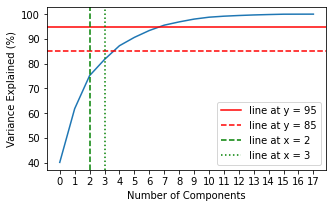

<Figure size 432x288 with 0 Axes>

In [ ]:
y = np.cumsum(pca.explained_variance_ratio_ * 100)
x = np.array(range(numberOfComponents))
plt.figure(figsize =(5, 3))
plt.plot(x,y)
plt.xlabel("Number of Components")
plt.ylabel("Variance Explained (%)")
plt.axhline(y=95, color='r',label='line at y = {}'.format(95))
plt.axhline(y=85, color='r',label='line at y = {}'.format(85), linestyle ='--')
plt.axvline(x=2, color='g',label='line at x = {}'.format(2), linestyle='--')
plt.axvline(x=3, color='g',label='line at x = {}'.format(3), linestyle=':')
plt.xticks(np.arange(0, numberOfComponents, 1))
plt.legend()
plt.show()
plt.savefig("Climate PCA.png")


In [ ]:
selectedIntercept = 85
x_val = math.ceil(np.interp(selectedIntercept, y, x))
print (f"x-axis value for explaining {selectedIntercept}% data is {x_val}")
print (f"This means that around {x_val} Principal components explain around {selectedIntercept}% of our data.")

x-axis value for explaining 85% data is 4
This means that around 4 Principal components explain around 85% of our data.


In [ ]:
pca.explained_variance_ratio_

array([4.00731459e-01, 2.17039855e-01, 1.33719079e-01, 6.52468617e-02,
       5.55360425e-02, 3.37440960e-02, 2.77630125e-02, 2.16003429e-02,
       1.32177839e-02, 1.12811357e-02, 7.69990088e-03, 4.09376119e-03,
       2.77413460e-03, 2.24250712e-03, 1.64395399e-03, 1.39583255e-03,
       1.43130393e-04, 1.27111346e-04])

Text(0, 0.5, 'Variance Explained (%)')

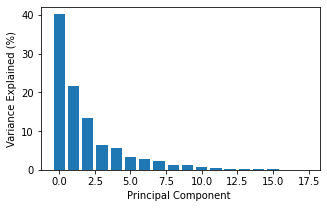

In [ ]:
plt.figure(figsize=(5,3))
plt.bar(np.array(range(numberOfComponents)) ,pca.explained_variance_ratio_[0:numberOfComponents]*100)
plt.xlabel("Principal Component ")
plt.ylabel("Variance Explained (%)")

In [ ]:
#pca.components_ = pca.components_[0:x_val]

In [ ]:
pca.components_ = pca.components_[0:x_val]
transformedData = pca.transform(dataForPCA)
transformed_df = pd.DataFrame(transformedData)
#plt.figure()
#plt.plot(transformedData[:,])

In [ ]:
transformedData.shape

(1593, 4)

In [ ]:
# transformed_df.cov()

In [ ]:
#@title
# plt.figure(figsize =(5, 3))
# plt.scatter(transformed_df[0], transformed_df[1])
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.savefig("Climate PC1 PC2.png")

<Figure size 432x288 with 0 Axes>

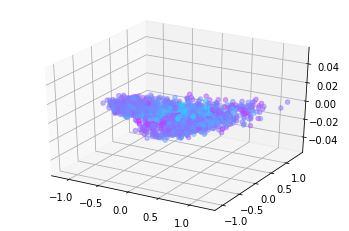

In [ ]:
plot3D = plt.figure()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = transformedData[:,0]
y = transformedData[:,1]
z = transformedData[:,2]
c = np.random.standard_normal(len(transformedData))
img = ax.scatter(x, y, c=z, cmap="cool", alpha=0.5)
plot3D.show()

In [ ]:
#@title
# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter3D(x, y, z, cmap='viridis', edgecolor='none')
# ax.set_title('surface');

#### (optionalsection)

Working with original data- Why/not we can't do PCA on directly/ 

In [ ]:
data2 = climateDataBasel
pca2 = PCA( n_components =x_val)
pca2.fit(data2)
#comment on the amount of variance, interpretability and the link with the original features

PCA(n_components=4)

In [ ]:
transformedData2 = pca2.transform(data2)
plt.figure ( figsize =(6 ,4))
#plt.plot ( transformedData2 [: ,0] , transformedData2 [: ,1] ,".")

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Text(0, 0.5, ' Variance Explained (%)')

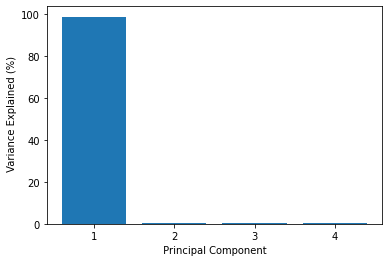

In [ ]:
plt.figure ( figsize =(6 ,4))
plt.bar ([1 ,2 ,3 ,4] ,pca2.explained_variance_ratio_*100 , tick_label =[1 ,2 ,3 ,4])
plt.xlabel (" Principal Component ")
plt.ylabel (" Variance Explained (%)")


Here we see that, if we do not standardize our data, the Principal component analysis gives very wrong results since the component ranges will influence the creation of the components. The ranking of the components is very skewed as well as it shows that only one component can explain more than 90% of the data.

## ***II.* Clustering**

Clustering is a data analysis technique that helps find similarities between data points in our set and groups the similar ones together. This helps us see patterns in our data and extrapolate on how our data is divided. In some cases, we need domain knowledge to understand the meaning of our data but clustering helps in getting a first impression of the unknown dataset. It is an unsupervised method of learning, implying the models doesn't need much input. The dataset is split into groups based on similarities and groups are separated based on the differences. 

Clustering methods available in current literature can be broadly classified into parameteric and non-parameteric methods. Parameteric methods need input from any of - number of clusters (K-Means etc.), bandwidth (Mean-Shift etc.), distance metric (Hierarchichal), threshold (BIRCH etc.) and many others. This paper evaluates performances of K-Means, Agglomerative and BIRCH models on Climate dataset.

### Preparation for clustering

In [ ]:
centralizedData = centralization(transformedData)

In [ ]:
dataForClustering = transformedData

In [ ]:
#@title
dataForClustering.shape

(1593, 4)

In [ ]:
#@title
# Importing packages
import scipy as sc
import scipy.cluster as scc
from scipy.spatial.distance import cdist

import sklearn as skl
from sklearn.cluster import KMeans 

### **K-Means**

K- Means is Partitioning based. It divides the data points into 'K' number of clusters. This is a user-defined value and susceptible to imperfection. 

We get 'K' number of centroid values around which the clusters are present.

We use normalized data for this process.

In [ ]:
#centroids , distortion = scc.vq.kmeans(dataForClustering , 5)

##### **Elbow Method**

 Distortion is the sum of square errors (SSE) 

In [ ]:
#@title
distortions= []
inertias = []
silhoutteScores = []
# distortionValues = {}
# inertiaValues = {}
for k in range(1,8):
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(dataForClustering)
    #cdist - is used to find the distance between a data point and the cluster center
    local_distortion = sum(np.min(cdist(dataForClustering, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) 
    #distortionValues[k] = local_distortion
    distortions.append(local_distortion)
    #inertiaValues[k] = kmeanModel.inertia_
    inertias.append(kmeanModel.inertia_)
    if k>1:
      silhoutteScore = skl.metrics.silhouette_score(dataForClustering, kmeanModel.labels_)
      silhoutteScores.append(silhoutteScore)
 

In [ ]:
#@title
# #@title
# from yellowbrick.cluster import KElbowVisualizer
# # Instantiate the clustering model and visualizer
# model = KMeans()
# visualizer = KElbowVisualizer(model, k=(1,10))
# visualizer.fit(normalizedData)        # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

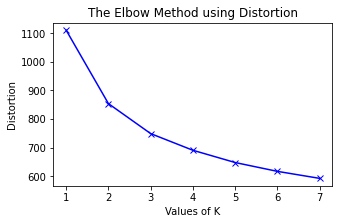

In [ ]:
#@title
plt.figure(figsize=(5,3))
plt.plot(range(1, 8), distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

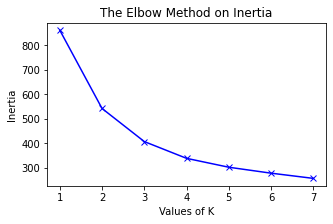

In [ ]:
#@title
plt.figure(figsize=(5,3))
plt.plot(range(1, 8), inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method on Inertia')
plt.show()


#### **Silhouette Analysis**

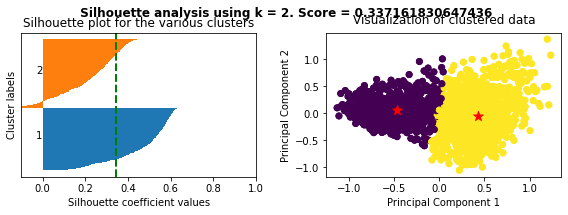

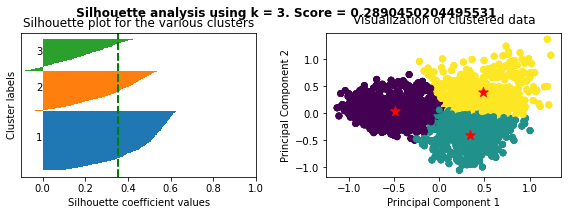

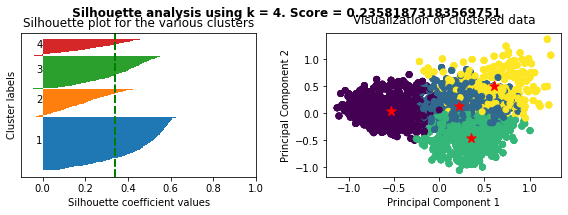

In [ ]:
#@title
# Now check silhouette coefficient
df1 = dataForClustering
for i,k in enumerate([2,3,4]):
    fig, ax = plt.subplots(1,2,figsize=(8,3))
    
    # Run the kmeans algorithm
    km = KMeans(n_clusters=k)
    y_predict = km.fit_predict(df1)
    centroids  = km.cluster_centers_
# get silhouette
    silhouette_vals = skl.metrics.silhouette_samples(df1,y_predict)
    #silhouette_vals
# silhouette plot
    y_ticks = []
    y_lower = y_upper = 0
    for i,cluster in enumerate(np.unique(y_predict)):
      cluster_silhouette_vals = silhouette_vals[y_predict ==cluster]
      cluster_silhouette_vals.sort()
      y_upper += len(cluster_silhouette_vals)
      
      ax[0].barh(range(y_lower,y_upper),
      cluster_silhouette_vals,height =1);
      ax[0].text(-0.03,(y_lower+y_upper)/2,str(i+1))
      y_lower += len(cluster_silhouette_vals)
          
      # Get the average silhouette score 
      avg_score = np.mean(silhouette_vals)
      ax[0].axvline(avg_score,linestyle ='--',
      linewidth =2,color = 'green')
      ax[0].set_yticks([])
      ax[0].set_xlim([-0.1, 1])
      ax[0].set_xlabel('Silhouette coefficient values')
      ax[0].set_ylabel('Cluster labels')
      ax[0].set_title('Silhouette plot for the various clusters');
        
      # scatter plot of data colored with labels
    
      ax[1].scatter(dataForClustering[:,0], dataForClustering[:,1] , c = y_predict)  ;
      ax[1].scatter(centroids[:,0],centroids[:,1], marker = '*' , c= 'r',s =100);
      ax[1].set_xlabel('Principal Component 1')
      ax[1].set_ylabel('Principal Component 2')
      ax[1].set_title('Visualization of clustered data', y=1.02)
        
    plt.tight_layout()
    plt.suptitle(f' Silhouette analysis using k = {k}. Score = {silhoutteScores[k]}',fontsize=12,fontweight = 'semibold')

plt.show()

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(clusters[0], clusters[1], clusters[2])
# plt.show()

#### K-Means implementation

In [ ]:
finalNumberOfClusters = 3
finalKmeansModel = KMeans(n_clusters= finalNumberOfClusters)

In [ ]:
startTimeKMean = time.time()
finalKmeansModel.fit(dataForClustering)
endTimeKMean = time.time()
print(f"Training time: {getTrainingTime(startTimeKMean, endTimeKMean)} ms")

Training time: 57.5366 ms


In [ ]:
finalKMeanslabels = finalKmeansModel.predict(dataForClustering)

In [ ]:
-
entroids  = finalKmeansModel.cluster_centers_

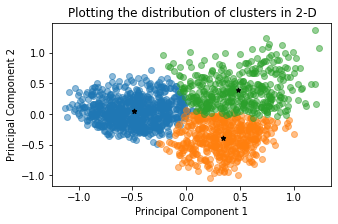

In [ ]:
#@title
plt.figure(figsize=(5,3))
indexForScatterplotx = 0
indexForScatterploty = 1
clusters = [[]]
centroids  = finalKmeansModel.cluster_centers_
plt.title("Plotting the distribution of clusters in 2-D")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
# plt.scatter(dataForClustering[:,indexForScatterplotx])
# dataForClustering.plot.scatter(dataForClustering[:,indexForScatterplotx],dataForClustering[:,indexForScatterploty])

for i in range( finalNumberOfClusters):
  filteredData = dataForClustering[finalKMeanslabels == i]
  clusters.append(filteredData)
  plt.scatter(filteredData[:,indexForScatterplotx], filteredData[:,indexForScatterploty], alpha=0.5)
  plt.scatter(centroids[:,0],centroids[:,1], marker = '*', c= 'black',s =20);
plt.show()
cluster_list_KMeans = clusters

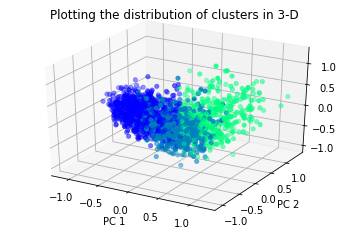

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.title("Plotting the distribution of clusters in 3-D")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
ax.scatter(dataForClustering[:,0], dataForClustering[:,1], dataForClustering[:,2], c=finalKMeanslabels, cmap='winter', linewidth=0.5);

#### Conclusion of K-Means

In [ ]:
print(f"Silhouette score for K-Means model is {round(skl.metrics.silhouette_score(dataForClustering,finalKMeanslabels),5) }")
print(f"Davies-Bouldin for K-Means model is {round(skl.metrics.davies_bouldin_score(dataForClustering,finalKMeanslabels),5) }")
print(f"Calinski-Harabasz Index for K-Means model is {round(skl.metrics.calinski_harabasz_score(dataForClustering,finalKMeanslabels),5) }")
print(f"Training time for K-Means model: {getTrainingTime(startTimeKMean, endTimeKMean)} ms")
print(f"Number of Clusters in K-Means model: {finalKmeansModel.n_clusters}")

Silhouette score for K-Means model is 0.3554
Davies-Bouldin for K-Means model is 1.19582
Calinski-Harabasz Index for K-Means model is 892.30763
Training time for K-Means model: 57.5366 ms
Number of Clusters in K-Means model: 3


### **Agglomerative**

Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them successively. This hierarchy of clusters is represented as a tree (or dendrogram). 

In [ ]:
#@title
#Function to calculate distance
#Euclidean distance
# def cal_distance(mat):
#   rows = mat.shape[0]
#   cols = mat.shape[1]
#   res_mat = np.zeros((rows, rows))
#   for i in range(rows-1):
#     for j in range(rows-1):
#       total = 0
#       for c in range(cols-1):
#         total += (mat.iloc[i,c] - mat.iloc[j,c])** 2
  
#       res_mat[i,j] = total ** 0.5
#   return res_mat

# def dist(p1, p2):
#   total = 0
#   for c in range(len(p1)):
#     total = total +  (p1[c] - p2[c])**2
#   return total** 0.5

Pdist is a scipy library method to calculate distances between the data points. We can pass a parameter to specify which kind of distance is needs to be computed. It returns an array containing distances of each data point from others. WE then need to conver it into vector of 'no. of rows' x 'no. of rows' format. We do that using the squareform method

In [ ]:
from scipy.spatial.distance import pdist
distanceDataEuclidean = pdist(dataForClustering, metric="euclidean")
distanceDataSqEuclidean = pdist(dataForClustering, metric="sqeuclidean")
distanceDataMahalanobis = pdist(dataForClustering, metric="mahalanobis")
distanceDataManhattan = pdist(dataForClustering, metric="cityblock")

In [ ]:
condensedDistanceEu= sc.spatial.distance.squareform(distanceDataEuclidean)
condensedDistanceSqEq = sc.spatial.distance.squareform(distanceDataSqEuclidean)
condensedDistanceMh = sc.spatial.distance.squareform(distanceDataMahalanobis)
condensedDistanceMa = sc.spatial.distance.squareform(distanceDataManhattan)

condensedDistance = condensedDistanceEu
#condensedDistance.shape

This paper uses scipy library to visualize dendrograms using different linkages (inter-cluster distances).

Performing single linkage on the Ward features improves the final clustering

[Paper => Learning representations from dendrograms]\

#### Linkages + Dendogram

In [ ]:
#linkagesData = scc.hierarchy.linkage(condensedDistance) #Try with single

In [ ]:
# plt.figure()
# scc.hierarchy.dendrogram(linkagesData, truncate_mode="lastp", p=12)
# plt.show()

In [ ]:
#scc.hierarchy.is_valid_linkage(linkagesData)

#### Average + Dendogram

The average of inter-node distances is used as the linkage between two nodes. 

In [ ]:
averagelinkagesData = scc.hierarchy.average(condensedDistance)
averagelinkagesDataMa = scc.hierarchy.average(condensedDistanceMa)
averagelinkagesDataMh = scc.hierarchy.average(condensedDistanceMh)

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:442: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='average', metric='euclidean')


In [ ]:
# plt.figure()
# #fig, axs = plt.subplots(1, 3 )
# # = plt.subplot(1,1,1)
# plt.subplot(2, 1, 1)
# s1.set_title("Average Euclidean distances")
# scc.hierarchy.dendrogram(averagelinkagesData, truncate_mode="lastp", p=10)
# # plt.show()

# # plt.figure()
# plt.subplot(2,2,3)
# s2.set_title("Average Manhattan distances")
# scc.hierarchy.dendrogram(averagelinkagesDataMa, truncate_mode="lastp", p=10)

# s3 = plt.subplot(2,2,4)
# s3.set_title("Average Mahanobalis distances")
# scc.hierarchy.dendrogram(averagelinkagesDataMh, truncate_mode="lastp", p=10)

# plt.show()

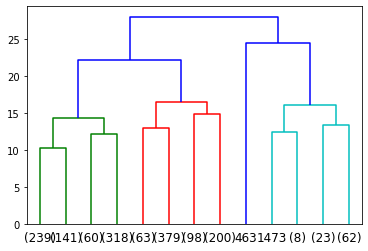

In [ ]:
plt.figure()
scc.hierarchy.dendrogram(averagelinkagesData, truncate_mode="level", p=3)
plt.show()

#### Ward + Dendogram

In [ ]:
condensedDistance = condensedDistanceSqEq
wardData = scc.hierarchy.ward(condensedDistance)

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [ ]:
scc.hierarchy.is_valid_linkage(wardData)

True

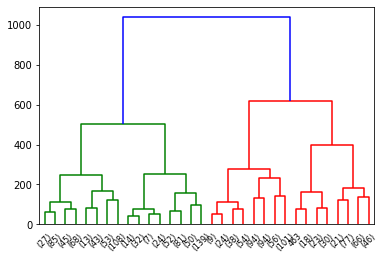

In [ ]:
plt.figure()
scc.hierarchy.dendrogram(wardData, truncate_mode="level", p=4)
plt.show()

#### Analysis of dendograms

In [ ]:
#@title
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(
            X_red[i, 0],
            X_red[i, 1],
            ".",
            color=plt.cm.nipy_spectral(labels[i] / 10.0),
            fontdict={"weight": "bold", "size": 9},
        )

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
aggClusterModel = skl.cluster.AgglomerativeClustering(affinity = "euclidean", linkage= "ward")
aggClusterModel.fit(dataForClustering)
aggClusterModel.n_clusters_

2

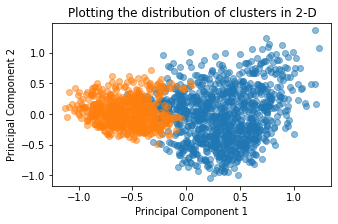

In [ ]:
#@title
plt.figure(figsize=(5,3))
indexForScatterplotx = 0
indexForScatterploty = 1
clusters = [[]]
labels = aggClusterModel.labels_
#aggClusterModel3.
plt.title("Plotting the distribution of clusters in 2-D")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
for i in range( finalNumberOfClusters):
  filteredData = dataForClustering[labels == i]
  clusters.append(filteredData)
  plt.scatter(filteredData[:,indexForScatterplotx], filteredData[:,indexForScatterploty], alpha=0.5)
plt.show()

In [ ]:
aggClusterModel3 = skl.cluster.AgglomerativeClustering(n_clusters=3,affinity = "euclidean", linkage= "ward")
startTimeaggClusterModel3 = time.time()
aggClusterModel3.fit(dataForClustering)
endTimeaggClusterModel3 = time.time()
print(f"Training time: {getTrainingTime(startTimeaggClusterModel3, endTimeaggClusterModel3)} ms")
aggClusterModel3.n_clusters
finalAggModellabels = aggClusterModel3.labels_

Training time: 60.2839 ms


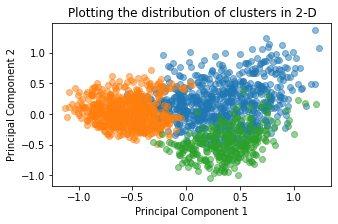

In [ ]:
#@title
plt.figure(figsize=(5,3))
indexForScatterplotx = 0
indexForScatterploty = 1
clusters = [[]]
labels = aggClusterModel3.labels_
#aggClusterModel3.
plt.title("Plotting the distribution of clusters in 2-D")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
for i in range( finalNumberOfClusters):
  filteredData = dataForClustering[labels == i]
  clusters.append(filteredData)
  plt.scatter(filteredData[:,indexForScatterplotx], filteredData[:,indexForScatterploty], alpha=0.5)
plt.show()

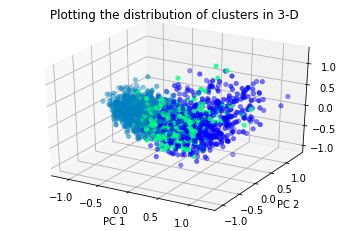

In [ ]:
#@title
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.title("Plotting the distribution of clusters in 3-D")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
ax.scatter(dataForClustering[:,0], dataForClustering[:,1], dataForClustering[:,2], c=aggClusterModel3.labels_, cmap='winter', linewidth=0.5);

#### Conclusion of Agglomerative

In [ ]:
print(f"Silhouette score for Agglomerative model is {round(skl.metrics.silhouette_score(dataForClustering,finalAggModellabels),5) }")
print(f"Davies-Bouldin for Agglomerative model is {round(skl.metrics.davies_bouldin_score(dataForClustering,finalAggModellabels),5) }")
print(f"Calinski-Harabasz Index for Agglomerative model is {round(skl.metrics.calinski_harabasz_score(dataForClustering,finalAggModellabels),5) }")
print(f"Training time for Agglomerative model:  {getTrainingTime(startTimeaggClusterModel3, endTimeaggClusterModel3)} ms")
print(f"Number of Clusters in Agglomerative model: {aggClusterModel3.n_clusters}")

Silhouette score for Agglomerative model is 0.29146
Davies-Bouldin for Agglomerative model is 1.31554
Calinski-Harabasz Index for Agglomerative model is 726.57091
Training time for Agglomerative model:  60.2839 ms
Number of Clusters in Agglomerative model: 3


### BIRCH

BIRCH
requires three parameters: the branching factor Br, the threshold T, and the cluster
count k

Definition of threshold:

The radius of the subcluster obtained by merging a new sample and the closest subcluster should be lesser than the threshold. Otherwise a new subcluster is started.

Since we are using scaled down data, we need to be careful of the radius value to set. 

In [ ]:
#pd.DataFrame(dataForClustering)[0]
print(f" Minimum values of all features \n{np.min(transformed_df)}")
print(f" Maximum values of all features \n{np.max(transformed_df)}")

 Minimum values of all features 
0   -1.126789
1   -1.051578
2   -1.011692
3   -0.668928
dtype: float64
 Maximum values of all features 
0    1.233353
1    1.372255
2    1.213780
3    0.860456
dtype: float64


Here we try setting different threshold values for the birch model. Trial and error shows that when the threshold crosses 0.7, we get convergence error. This means that the sub-clusters are converging to form larger clusters that is different from what the birch model is predicting. 

#### Determining Threshold

In [ ]:
#@title
silhoutteScores1 = []
silhoutteScores2 = []
for i in np.arange(0,0.7,0.1):
  birchModel1 = skl.cluster.Birch(threshold= i, branching_factor = 2)
  birchModel2 = skl.cluster.Birch(threshold= i, branching_factor= 50)
  birchModelClusterLabels1= birchModel1.fit_predict(dataForClustering)
  birchModelClusterLabels2= birchModel2.fit_predict(dataForClustering)
  localSilhoutte1 = round(skl.metrics.silhouette_score(dataForClustering, birchModelClusterLabels1),5)
  localSilhoutte2 = round(skl.metrics.silhouette_score(dataForClustering, birchModelClusterLabels2),5)
  silhoutteScores1.append(localSilhoutte1)
  silhoutteScores2.append(localSilhoutte2)

print (silhoutteScores1)
print (silhoutteScores2)

[0.29146, 0.31312, 0.26146, 0.24856, 0.24962, 0.31159, 0.33442]
[0.29146, 0.3202, 0.29521, 0.28407, 0.25879, 0.12982, 0.33571]


We find that threshold values around 0.6 give the highest silhoutte score.

#### Models

In [ ]:
birchModel1 = skl.cluster.Birch(threshold=0.6, branching_factor= 2)
birchModel1.fit(dataForClustering)
birchModelClusterLabels1 = birchModel1.predict(dataForClustering)

In [ ]:
birchModel2 = skl.cluster.Birch(threshold=0.6, branching_factor= 50)
startTimeBirchModel2 = time.time()
birchModel2.fit(dataForClustering)
endTimeBirchModel2 = time.time()
print(f"Training time: {getTrainingTime(startTimeBirchModel2, endTimeBirchModel2)} ms")

birchModelClusterLabels2= birchModel2.predict(dataForClustering)

Training time: 33.56552 ms


Text(0.5, 1.0, 'Scatter plot for BIRCH model')

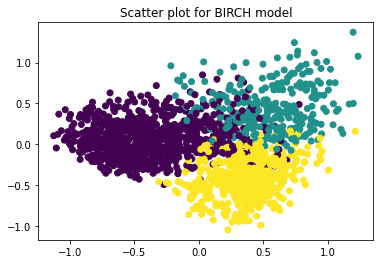

In [ ]:
plt.scatter(dataForClustering[:, 0], dataForClustering[:, 1], c = birchModelClusterLabels1)
plt.title("Scatter plot for BIRCH model")

In [ ]:
birchModel2.subcluster_centers_

array([[-0.42180908,  0.04431787, -0.05948461, -0.02794794],
       [ 0.476103  ,  0.15829127, -0.20108905,  0.10464813],
       [ 0.33236981, -0.49858857,  0.12086133, -0.00156678],
       [ 0.79716336,  0.54869081,  0.35137093, -0.12527842],
       [ 0.07199854,  0.44638688,  0.29938492,  0.05543968]])

In [ ]:
birchModelFinal = birchModel2
finalBirchlabels = birchModelFinal.labels_

#### Conclusion of BIRCH

In [ ]:
print(f"Silhouette score for BIRCH model is {round(skl.metrics.silhouette_score(dataForClustering,finalBirchlabels),5) }")
print(f"Davies-Bouldin for BIRCH model is {round(skl.metrics.davies_bouldin_score(dataForClustering,finalBirchlabels),5) }")
print(f"Calinski-Harabasz Index for BIRCH model is {round(skl.metrics.calinski_harabasz_score(dataForClustering,finalBirchlabels),5) }")
print(f"Training time for BIRCH model:  {getTrainingTime(startTimeBirchModel2, endTimeBirchModel2)} ms")
print(f"Number of Clusters in BIRCH model: {aggClusterModel3.n_clusters}")

Silhouette score for BIRCH model is 0.33571
Davies-Bouldin for BIRCH model is 1.22326
Calinski-Harabasz Index for BIRCH model is 834.65187
Training time for BIRCH model:  33.56552 ms
Number of Clusters in BIRCH model: 3


### Others - 

EM (Expectation Maximization) - Model-based 
OR
Mean Shift -  centroid-based  

#### DBSCAN

In [ ]:
# from sklearn.cluster import DBSCAN
# from sklearn import metrics
# import numpy as np

# clustering = DBSCAN(eps=0.5, min_samples=100).fit(dataForClustering)
# #Storing the labels formed by the DBSCAN
# labels = clustering.labels_
# # measure the performance of dbscan algo
# #Identifying which points make up our “core points”
# core_samples = np.zeros_like(labels, dtype=bool)
# core_samples[clustering.core_sample_indices_] = True
# print(core_samples)
# #Calculating "the number of clusters"
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# print(n_clusters_)
# #Computing "the Silhouette Score"
# print("Silhouette Coefficient: ", metrics.silhouette_score(dataForClustering, labels))

#### HDBSCAN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
# %matplotlib inline
# sns.set_context('poster')
# sns.set_style('white')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [ ]:
# !pip install hdbscan
# import hdbscan

In [ ]:
# clusterer = hdbscan.HDBSCAN(min_cluster_size=finalNumberOfClusters, gen_min_span_tree=True)
# clusterer.fit(normalizedData)

In [ ]:
# hdbscan.HDBSCAN(algorithm='best', alpha=0.3, approx_min_span_tree=True,
#     gen_min_span_tree=True, leaf_size=40, 
#     metric='euclidean', min_cluster_size=finalNumberOfClusters, min_samples=None, p=None)

In [ ]:
# clusterer.minimum_spanning_tree_.plot()

In [ ]:
# palette = sns.color_palette()
# cluster_colors = [sns.desaturate(palette[col], sat)
#                   if col > 1 else (0.5, 0.5, 0.5) for col, sat in
#                   zip(clusterer.labels_, clusterer.probabilities_)]
# plt.scatter(dataForClustering[:,[0]], dataForClustering[:,[1]], c=cluster_colors, **plot_kwds)

In [ ]:
# dbscanlabels = clusterer.labels_

In [ ]:
# len(clusterer.labels_)

In [ ]:
#number_of_unique_values = len(a_set)
#number_of_unique_values

### Evaluation Metrics


> Metrics moved under each model



In [ ]:
# silhoutteScoreKMeans = skl.metrics.silhouette_score(dataForClustering, kmeanModel.labels_)
# silhoutteScoreAgg= skl.metrics.silhouette_score(dataForClustering, aggClusterModel3.labels_)
# print("Silhoutte Score for K-Means model: ", silhoutteScoreKMeans)
# print("Silhoutte Score for Agglomerative model: ", silhoutteScoreAgg)

In [ ]:
# dBKMeans = skl.metrics.davies_bouldin_score(dataForClustering, kmeanModel.labels_)
# dBAgg = skl.metrics.davies_bouldin_score(dataForClustering, aggClusterModel3.labels_)
# print("Silhoutte Score for K-Means model: ", dBKMeans)
# print("Silhoutte Score for Agglomerative model: ", dBAgg)

In [ ]:
# CHKMeans = skl.metrics.calinski_harabasz_score(dataForClustering, kmeanModel.labels_)
# CHAgg = skl.metrics.calinski_harabasz_score(dataForClustering, aggClusterModel3.labels_)
# print("Calinski-Harabasz index  for K-Means model: ", CHKMeans)
# print("Calinski-Harabasz index for Agglomerative model: ", CHAgg)

#### Dunn Index

In [ ]:
# !pip install jqmcvi
# import jqmcvi as jc
# dunnKMeans = js.base.dunn(cluster_list_KMeans)

# **Video Data Set**

## Preprocessing

### **0. Reading Data**

In [ ]:
# Reading data
images_data = pd.read_csv("WLA.csv", header=None, names =["Width","Length", "Area"])
labels = pd.read_csv("Labels.csv", header=None, names =["Label"])

### **1. Missing values**

In [ ]:
images_data.isnull().sum()

Width     0
Length    0
Area      0
dtype: int64

### *Plotting frames data*

To check if our data follows Gaussian distribution, we are plotting histograms for all the features, since there are only 3 features here.

<Figure size 432x288 with 0 Axes>

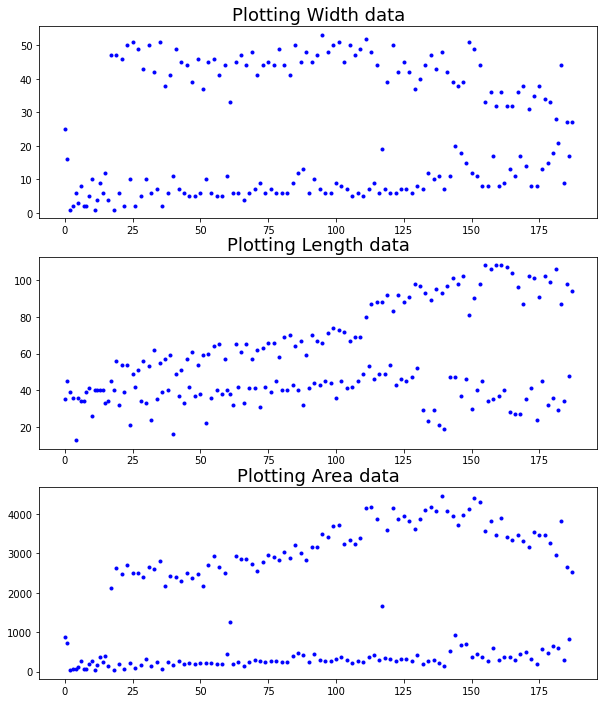

In [ ]:
plt.figure()
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,12))
for i in range(3):
  ax[i].plot(images_data.iloc[:,i],"b.")
  ax[i].set_title("Plotting "+ images_data.columns[i]+ " data",  fontsize=18)

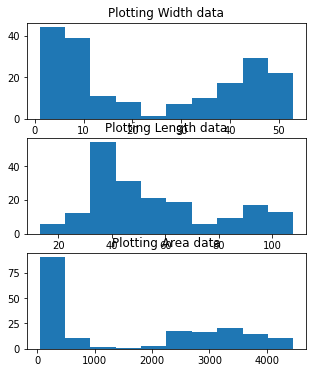

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5,6))
for i in range(3):
  ax[i].hist(images_data.iloc[:,i])
  ax[i].set_title("Plotting "+ images_data.columns[i]+ " data")
plt.savefig("Video histograms.png")


As can be seen from the histograms for Length, Width and Area columns, the distribution is not Normal.

In [ ]:
images_data.describe()

,Width,Length,Area
count,188.000000,188.000000,188.000000
mean,23.952128,55.367021,1621.968085
std,18.011667,24.053158,1512.415110
min,1.000000,13.000000,39.000000
25%,7.000000,38.000000,263.000000
50%,16.500000,46.500000,602.000000
75%,44.000000,69.000000,3020.250000
max,53.000000,108.000000,4464.000000


### **2. Standardization**

In [ ]:
images_standard_df = standardization(images_data)

### **3. Global Outliers/ Anomaly Detection**

In [ ]:
print (images_standard_df.applymap(lambda x: (x> 3 or x < -3)).sum())

Width     0
Length    0
Area      0
dtype: int64


The Z-score evaluation tell us that there are no outliers in this dataset. But we can use different density estimation methods like-  kernel density estimation (**KDE**) and the recursive density estimation (**RDE**) that can help in anomaly detection.

### **4. Normalization**

In [ ]:
images_normalized_df = normalization(images_data)

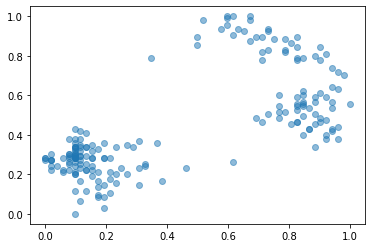

In [ ]:
plt.figure()
plt.scatter(images_normalized_df["Width"], images_normalized_df["Length"], alpha=0.5)

### **5. Feature Selection** 

#### **Correlation**

In [ ]:
# write why we are using pearson's correlation -> assumptions, conditions 
#images_data.corr("kendall")
print ("Covariance table - \n {0} \n".format(images_standard_df.cov() ))
print ("Correlation table - \n", images_standard_df.corr())

Covariance table - 
            Width    Length      Area
Width   1.000000  0.686441  0.929961
Length  0.686441  1.000000  0.887880
Area    0.929961  0.887880  1.000000 

Correlation table - 
            Width    Length      Area
Width   1.000000  0.686441  0.929961
Length  0.686441  1.000000  0.887880
Area    0.929961  0.887880  1.000000


In [ ]:
images_standard_df.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,Width,Length,Area
Width,1.00,0.69,0.93
Length,0.69,1.00,0.89
Area,0.93,0.89,1.00


Since area is highly correlated to the other two features, we can remove it. We keep length and width only

In [ ]:
selectedFeaturesForImageDS = [ "Width", "Length"]
imagesFEDataset = images_standard_df[selectedFeaturesForImageDS]
print(imagesFEDataset.shape)
print(imagesFEDataset.head())

(188, 2)
      Width    Length
0  0.058177 -0.846750
1 -0.441499 -0.431005
2 -1.274292 -0.680452
3 -1.218773 -0.805176
4 -0.996694 -1.761391


### **6. Feature Extraction**

If we consider video as a set of images, we can use FE methods that pertain to an individual image.

1.   CNN
2.   Histogram of Gradients

But for video data, this will be computationally very high. In video data, we can use the dependency of one frame on the other one.


Our video dataset has only 2 features after selection and doesn't need dimensionality reduction.


#### **PCA** (not required)

In [ ]:
centralizedImagesData = centralization(imagesFEDataset)

In [ ]:
dataForPCA = images_standard_df
#print (dataForPCA.head())
pca_VideoData = PCA()
pca_VideoData.fit(dataForPCA)
pca_VideoData.explained_variance_

array([2.67380092, 0.31526081, 0.01093827])

Text(0, 0.5, 'Variance Explained (%)')

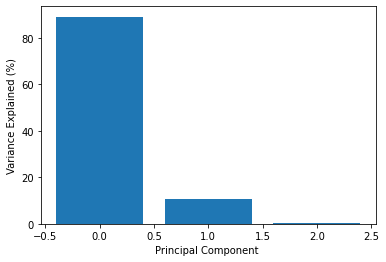

In [ ]:
#@title
plt.bar (np.array(range(3)) ,pca_VideoData.explained_variance_ratio_[0:3]*100)
plt.xlabel("Principal Component ")
plt.ylabel("Variance Explained (%)")

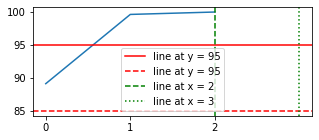

In [ ]:
#@title
y = np.cumsum(pca_VideoData.explained_variance_ratio_ * 100)
numberOfComponents = 3
x = np.array(range(3))
plt.figure(figsize =(5, 2))
plt.plot(x,y)
plt.axhline(y=95, color='r',label='line at y = {}'.format(95))
plt.axhline(y=85, color='r',label='line at y = {}'.format(95), linestyle ='--')
plt.axvline(x=2, color='g',label='line at x = {}'.format(2), linestyle='--')
plt.axvline(x=3, color='g',label='line at x = {}'.format(3), linestyle=':')
plt.xticks(np.arange(0, numberOfComponents, 1))
plt.legend()
plt.show()


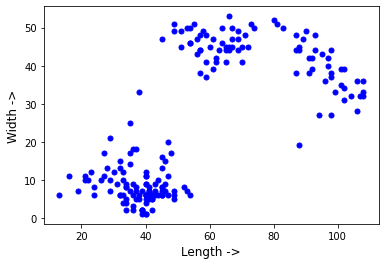

In [ ]:
plt.figure()
plt.scatter(images_data["Length"], images_data["Width"], c='blue', s=25)
plt.xlabel("Length ->",  fontsize=12)
plt.ylabel("Width ->",  fontsize=12)
plt.show()

## **II. Classification**

### Preparation for Classification

In [ ]:
selectedFeaturesForImageDS

['Width', 'Length']

Write about classification> Why we are using it for this.

In [ ]:
from sklearn.tree import DecisionTreeClassifier , plot_tree
import sklearn.tree as skTree
import sklearn.ensemble as skEnsemble

In [ ]:
numberOfClasses = 2
labelledData = labels
dataForClassification = images_data[selectedFeaturesForImageDS]

# Removing the first 16 lines of data points since we they are not useful for training. 
# They all belong to the same Class - 'Bike'
# We will instead use them for testing since this is homogenous data and model should predict the same label for all 
dataForClassificationTesting16 = dataForClassification[:16]
labelledDataForTesting16 = labelledData[:16]
dataForClassification = dataForClassification[16:]
labelledData = labelledData[16:]

In [ ]:
dataForClassification.head()


,Width,Length
16,4,34
17,47,45
18,1,40
19,47,56
20,6,32


Before we can start clustering our data, we need to split our dataset into training data and testing data for validating our generated clusters. Here we are taking a 70 / 30 split of our dataset.

dataForClassificationTrain-> This dataset is used by the model to learn.

labelledDataTrain-> Dataset containing correct labels for training data.

dataForClassificationTest -> This dataset is used by the model to test for correct predictions.

labelledDataTest -> Dataset containing correct labels for testing data.

In [ ]:
splitValue = 0.3
dataForClassificationTrain, dataForClassificationTest, labelledDataTrain, labelledDataTest =  skl.model_selection.train_test_split(dataForClassification, 
                                                                                                                                   labelledData, test_size=splitValue,
                                                                                                                                   random_state=42,
                                                                                                                                   stratify=labelledData)

# we use stratify parameter to split our data set equally between both the labels.
# This ensure balance during the training phase
# Equal number of Bike class and Car class data points are present in the training dataset
# this helps our model to train better

# We use random_state to set seed and split the data in the same manner over multiple runs.
# This ensure consistent result 

#test_size defines percentage of data to be split. We select 30% 

In [ ]:
dataForClassificationTrain.shape
print (f"After splitting the data into training and testing data sets, we have {dataForClassificationTrain.shape[0]} rows of data for training and {dataForClassificationTest.shape[0]} rows of data for testing.")

After splitting the data into training and testing data sets, we have 120 rows of data for training and 52 rows of data for testing.


In [ ]:
dataForClassificationTestWith16 = pd.concat([ dataForClassificationTest, dataForClassificationTesting16])
labelledDataTestWith16 = pd.concat([ labelledDataTest, labelledDataForTesting16])
print (f"After merging the 16 rows of Class 1 label, we have {dataForClassificationTestWith16.shape[0]} rows of data for testing.")

After merging the 16 rows of Class 1 label, we have 68 rows of data for testing.


### Decision Trees

In [ ]:
#Training the Decision Tree model using DecisionTreeClassifier
decisionTreeModel = DecisionTreeClassifier( criterion = "gini")

Learning curve

 Cross-validation is a resampling method that uses different portions of the data to test and train a model on different iterations. Learning curve (or training curve) show the optimal value of a model's loss function for a training set against this loss function evaluated on a validation data set with same parameters as produced the optimal function. It is a tool to find out how much a machine model benefits from adding more training data and whether the estimator suffers more from a variance error or a bias error. If both the validation score and the training score converge to a value that is too low with increasing size of the training set, it will not benefit much from more training data

In [ ]:
learningCurveDT = skl.model_selection.learning_curve(estimator = decisionTreeModel, X = dataForClassificationTrain, y = labelledDataTrain, 
                                   return_times = True)

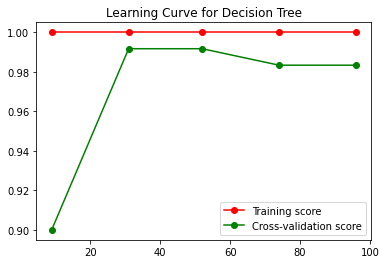

In [ ]:
train_sizes, train_scores, test_scores, fit_times, _ = learningCurveDT
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)
# Plot learning curve
plt.figure()
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score" )
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
plt.title("Learning Curve for Decision Tree")
plt.legend(loc="best")

This shows that the optimal size of the training dataset is around 30 and 50 data points. We take the average and train our model on 40 data points. Since we have 120 data points in our training data set, we can run a fit and validate our model on multiple runs. 



120/ 40 = 3

We can extrapolate the number of folds in our cross-validation method from this. A 3-fold cross validation seems the most optimal run for fitting and validating our model.

In [ ]:
crossValidationGenerator = 3
#Cross_validate method returns 3 sets of values -
# fit_time - this returns an array of time taken to fit the model on the sample set
# score_time -
# test_score (this case, accuracy) - an array of accuracies for each model
decisionTreeCV = skl.model_selection.cross_validate(estimator = decisionTreeModel, X = dataForClassificationTrain, y = labelledDataTrain, return_estimator=True,
                                                    cv= crossValidationGenerator, scoring='accuracy')
#decisionTreeModelFit = decisionTreeModel.fit(dataForClassificationTrain, labelledDataTrain)


In [ ]:
decisionTreeCV

{'estimator': [DecisionTreeClassifier(),
  DecisionTreeClassifier(),
  DecisionTreeClassifier()],
 'fit_time': array([0.00804257, 0.00382614, 0.00367451]),
 'score_time': array([0.00213003, 0.00182772, 0.00186157]),
 'test_score': array([0.975, 1.   , 0.975])}

In [ ]:
# We pick the estimator with best accuracy
selectedEstimatorDT = 1
decisionTreeModel = decisionTreeCV["estimator"][selectedEstimatorDT]

In [ ]:
#Training the data on the complete training dataset
startTimeDT = time.time()
decisionTreeModel.fit(dataForClassificationTrain, labelledDataTrain)
endTimeDT = time.time()

print(f"Training time: {getTrainingTime(startTimeDT, endTimeDT)} ms")

Training time: 16.56342 ms


In [ ]:
predictedLabelsDT = decisionTreeModel.predict(dataForClassificationTest)

In [ ]:
#Calculating accuracy of this model
accDT = decisionTreeModel.score(dataForClassificationTest, labelledDataTest)
print(f"Accurary of Decision Tree model trained on {round ((1-splitValue)* 100) }% data points is {round(accDT*100, 5)}%")

Accurary of Decision Tree model trained on 70% data points is 98.07692%


We also test the performance of our classfier on the 16 rows of data that we removed earlier since it contained only 1 label. 

In [ ]:
predictedLabelsDT16 = decisionTreeModel.predict(dataForClassificationTesting16)
accDT16 = decisionTreeModel.score(dataForClassificationTesting16, labelledDataForTesting16)
#print (predictedLabelsDT16)
print (f"Accuracy of prediction on test set with only Class 1 (Bike) labels - {accDT16 * 100} %")

Accuracy of prediction on test set with only Class 1 (Bike) labels - 93.75 %


Here we see that our model is not accurate.

In [ ]:
# confusionMatrixDecisionTree16 = skl.metrics.confusion_matrix(labelledDataForTesting16, predictedLabelsDT16, labels=[1, 2])
# scatterMatrixDT16 = skl.metrics.ConfusionMatrixDisplay(confusion_matrix= confusionMatrixDecisionTree16)
# scatterMatrixDT16.plot()

In [ ]:
decisionTreeModel.feature_importances_

array([0.96721311, 0.03278689])

Plotting Confusion Matrix for Decision Tree model 

In [ ]:
predictedLabelsDTWith16 = decisionTreeModel.predict(dataForClassificationTestWith16)

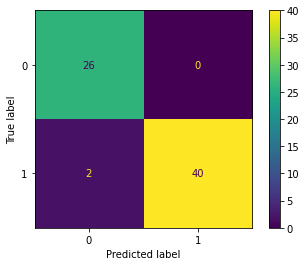

In [ ]:
confusionMatrixDecisionTree = skl.metrics.confusion_matrix(labelledDataTestWith16, predictedLabelsDTWith16, labels=[1, 2])
scatterMatrixDT = skl.metrics.ConfusionMatrixDisplay(confusion_matrix= confusionMatrixDecisionTree)
scatterMatrixDT.plot()

In [ ]:
accDTWith16 = decisionTreeModel.score(dataForClassificationTestWith16, labelledDataTestWith16)
#print (predictedLabelsDT16)
print (f"Accuracy of prediction on test set is - {round(accDTWith16 * 100, 5)} %")

Accuracy of prediction on test set is - 97.05882 %


In [ ]:
# y_score = decisionTreeModel.decision_function(dataForClassificationTest)

# fpr, tpr, _ = roc_curve(labelledDataTest, y_score, pos_label=decisionTreeModel.classes_[1])
# # roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
# prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=decisionTreeModel.classes_[1])
# pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

Text(0.5, 1.0, 'RocCurveDisplay for Decision Tree')

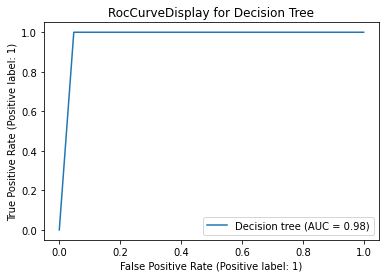

In [ ]:
rocCurveDisaply = skl.metrics.RocCurveDisplay.from_estimator( decisionTreeModel, dataForClassificationTestWith16, labelledDataTestWith16, pos_label=1, name="Decision tree")
rocCurveDisaply.ax_.set_title("RocCurveDisplay for Decision Tree")

In [ ]:
decisionTreeModel.tree_.impurity

array([0.5      , 0.       , 0.0322494, 0.       , 0.       ])

Text(0.5, 1.0, 'Decision Tree Classifier')

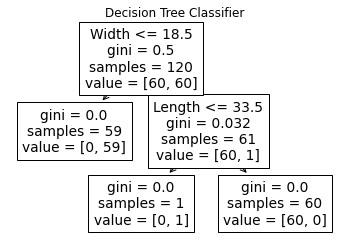

In [ ]:
skl.tree.plot_tree(decisionTreeModel, feature_names = ["Width", "Length"])
plt.title("Decision Tree Classifier")

In [ ]:
#skl.metrics.precision_recall_curve(labelledDataTest, predictedLabels, pos_label={1,2})

In [ ]:
print (f"Accuracy - {round(accDT * 100,5)} %")
print ("Recall score - ", round(skl.metrics.recall_score(labelledDataTest, predictedLabelsDT),5 ))
print ("Precision score - ", round(skl.metrics.precision_score(labelledDataTest, predictedLabelsDT),5) )
print ("F1 score - ", round(skl.metrics.f1_score(labelledDataTest, predictedLabelsDT),5))
print(f"Training time: {getTrainingTime(startTimeDT, endTimeDT)} ms")

#print ("precision_recall_fscore_support -  ", skl.metrics.precision_recall_fscore_support(labelledDataTest, predictedLabels))

Accuracy - 98.07692 %
Recall score -  1.0
Precision score -  0.96296
F1 score -  0.98113
Training time: 16.56342 ms


#### Random Forest Classifier

In [ ]:
labelledDataTrainArray = labelledDataTrain.values.ravel()
len(labelledDataTrainArray)

120

In [ ]:
randomForestModel = skEnsemble.RandomForestClassifier(n_estimators=2, criterion="gini", random_state= 42, bootstrap= False)

startTimeRF = time.time()
randomForestModelFit = randomForestModel.fit(dataForClassificationTrain, labelledDataTrainArray)
endTimeRF = time.time()
print(f"Training time: {getTrainingTime(startTimeRF, endTimeRF)} ms")

predictedLabelsRF = randomForestModel.predict(dataForClassificationTest)

Training time: 11.1804 ms


In [ ]:
#Calculating accuracy of this model
accRF = round(skl.metrics.accuracy_score(labelledDataTest, predictedLabelsRF),5 )
#accRF = randomForestModel.score(dataForClassificationTest, labelledDataTest)
print(f"Accurary of Random Forest Classifier model trained on {round ((1-splitValue)* 100) }% data points is {round(accRF*100, 5)}%")

Accurary of Random Forest Classifier model trained on 70% data points is 98.077%


In [ ]:
print (f"Accuracy - {round(accRF * 100,5)} %")
print ("Recall score - ", round(skl.metrics.recall_score(labelledDataTest, predictedLabelsRF),5 ))
print ("Precision score - ", round(skl.metrics.precision_score(labelledDataTest, predictedLabelsRF),5) )
print ("F1 score - ", round(skl.metrics.f1_score(labelledDataTest, predictedLabelsRF),5))
print(f"Training time: {getTrainingTime(startTimeRF, endTimeRF)} ms")

#print ("precision_recall_fscore_support -  ", skl.metrics.precision_recall_fscore_support(labelledDataTest, predictedLabels))

Accuracy - 98.077 %
Recall score -  1.0
Precision score -  0.96296
F1 score -  0.98113


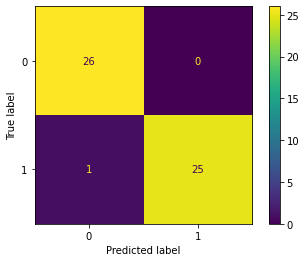

In [ ]:
confusionMatrixRandomForest= skl.metrics.confusion_matrix(labelledDataTest, predictedLabelsRF, labels=[1, 2])
scatterMatrixRF = skl.metrics.ConfusionMatrixDisplay(confusion_matrix= confusionMatrixRandomForest)
scatterMatrixRF.plot()

Text(0.5, 1.0, 'Random Forest Classifier - Estimator 1')

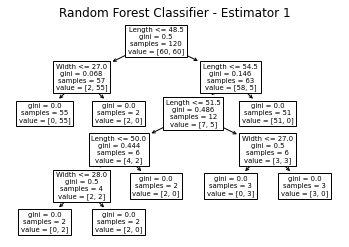

In [ ]:
skl.tree.plot_tree(randomForestModel.estimators_[0],feature_names = ["Width", "Length"])
plt.title("Random Forest Classifier - Estimator 1")

Text(0.5, 1.0, 'Random Forest Classifier - Estimator 2')

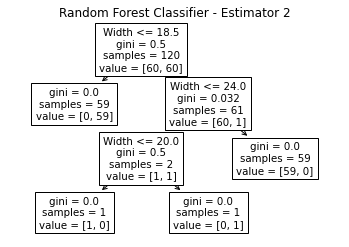

In [ ]:
skl.tree.plot_tree(randomForestModel.estimators_[1], feature_names = ["Width", "Length"])
plt.title("Random Forest Classifier - Estimator 2")


### Extra Tree Classifier

In [ ]:
#extraTreeModel = skTree.ExtraTreeClassifier(criterion="gini", random_state=42)

extraTreeModel = skl.ensemble.ExtraTreesClassifier(n_estimators=2, criterion="gini", random_state=42)

In [ ]:
learningCurveET = skl.model_selection.learning_curve(estimator = extraTreeModel, X = dataForClassificationTrain, y = labelledDataTrainArray, 
                                   return_times = True)

Text(0, 0.5, 'Score')

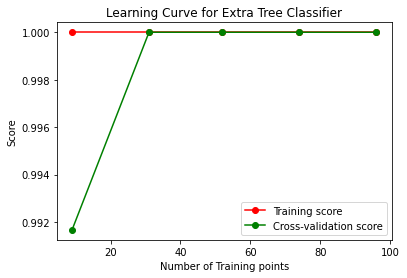

In [ ]:
train_sizes, train_scores, test_scores, fit_times, _ = learningCurveET
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)
# Plot learning curve
plt.figure()
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score" )
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
plt.title("Learning Curve for Extra Tree Classifier")
plt.legend(loc="best")
plt.xlabel("Number of Training points")
plt.ylabel("Score")

In [ ]:
crossValidationGenerator = 4
#Cross_validate method returns 3 sets of values -
# fit_time - this returns an array of time taken to fit the model on the sample set
# score_time -
# test_score (this case, accuracy) -
extraTreeCV = skl.model_selection.cross_validate(estimator = extraTreeModel, X = dataForClassificationTrain, y = labelledDataTrainArray, return_estimator=True,
                                                    cv= crossValidationGenerator, scoring='accuracy')
#decisionTreeModelFit = decisionTreeModel.fit(dataForClassificationTrain, labelledDataTrain)


In [ ]:
extraTreeCV

{'estimator': [ExtraTreesClassifier(n_estimators=2, random_state=42),
  ExtraTreesClassifier(n_estimators=2, random_state=42),
  ExtraTreesClassifier(n_estimators=2, random_state=42),
  ExtraTreesClassifier(n_estimators=2, random_state=42)],
 'fit_time': array([0.00917697, 0.00613236, 0.00586939, 0.00854135]),
 'score_time': array([0.0053525 , 0.00277352, 0.00423312, 0.00334382]),
 'test_score': array([1., 1., 1., 1.])}

In [ ]:
# We pick the estimator with best accuracy and low fit_time
selectedEstimatorET = 1
extraTreeModel = extraTreeCV["estimator"][selectedEstimatorET]

In [ ]:
startTimeET = time.time()
extraTreeModel.fit(dataForClassificationTrain, labelledDataTrainArray)
endTimeET = time.time()
print(f"Training time: {getTrainingTime(startTimeET, endTimeET)} ms")

Training time: 10.80251 ms


In [ ]:
predictedLabelsET = extraTreeModel.predict(dataForClassificationTest)

In [ ]:
#Calculating accuracy of this model
accEF = round(skl.metrics.accuracy_score(labelledDataTest, predictedLabelsET),5 )
print(f"Accurary of Extra Tree Classifier model trained on {round ((1-splitValue) * 100) }% data points is {round(accEF *100, 5)}%")

Accurary of Extra Tree Classifier model trained on 70% data points is 100.0%


In [ ]:
print (f"Accuracy - {accEF * 100 } %")
print ("Recall score - ", round(skl.metrics.recall_score(labelledDataTest, predictedLabelsET),5 ))
print ("Precision score - ", round(skl.metrics.precision_score(labelledDataTest, predictedLabelsET),5) )
print ("F1 score - ", round(skl.metrics.f1_score(labelledDataTest, predictedLabelsET),5))
#print ("precision_recall_fscore_support -  ", skl.metrics.precision_recall_fscore_support(labelledDataTest, predictedLabels))

Accuracy - 100.0 %
Recall score -  1.0
Precision score -  1.0
F1 score -  1.0


Text(0.5, 1.0, 'Confusion matrix for Extra Tree Classifier')

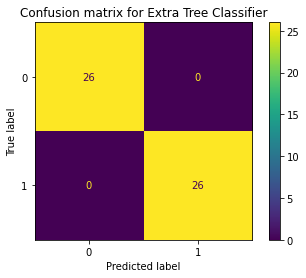

In [ ]:
confusionMatrixExtraTree = skl.metrics.confusion_matrix(labelledDataTest, predictedLabelsET, labels=[1, 2])
scatterMatrixET = skl.metrics.ConfusionMatrixDisplay(confusion_matrix= confusionMatrixExtraTree)
scatterMatrixET.plot()
plt.title("Confusion matrix for Extra Tree Classifier")

We also test the performance of our classfier on the 16 rows of data that we removed earlier since it contained only 1 label. 

In [ ]:
predictedLabelsET16 = extraTreeModel.predict(dataForClassificationTesting16)
accET16 = extraTreeModel.score(dataForClassificationTesting16, labelledDataForTesting16)
print (f"Accuracy of prediction on test set with only Class 1 (Bike) labels - {accET16 * 100} %")

Accuracy of prediction on test set with only Class 1 (Bike) labels - 93.75 %


Here we see that our model is not accurate.

Plotting Confusion Matrix for Extra Tree model 

In [ ]:
predictedLabelsETWith16 = extraTreeModel.predict(dataForClassificationTestWith16)

Text(0.5, 1.0, 'Confusion matrix for Extra Tree Classifier With Extra Test Data')

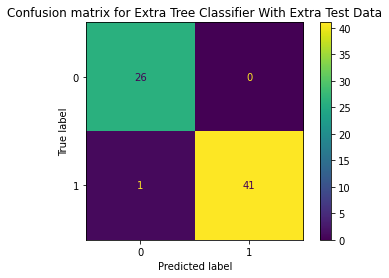

In [ ]:
confusionMatrixExtraTree = skl.metrics.confusion_matrix(labelledDataTestWith16, predictedLabelsETWith16, labels=[1, 2])
scatterMatrixET = skl.metrics.ConfusionMatrixDisplay(confusion_matrix= confusionMatrixExtraTree)
scatterMatrixET.plot()
plt.title("Confusion matrix for Extra Tree Classifier With Extra Test Data")

In [ ]:
accETWith16 = skl.metrics.accuracy_score(labelledDataTestWith16, predictedLabelsETWith16)
#extraTreeModel.score(dataForClassificationTestWith16, labelledDataTestWith16)
#print (predictedLabelsDT16)
print (f"Accuracy of prediction on test set is - {round(accETWith16 * 100, 5)} %")

Accuracy of prediction on test set is - 98.52941 %


Text(0.5, 1.0, 'Extra Forest Classifier - Estimator 1')

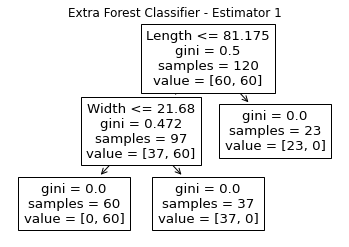

In [ ]:
skl.tree.plot_tree(extraTreeModel.estimators_[0], feature_names=["Width", "Length"])
plt.title("Extra Forest Classifier - Estimator 1")

Text(0.5, 1.0, 'Extra Forest Classifier - Estimator 2')

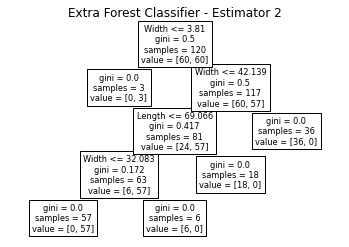

In [ ]:
skl.tree.plot_tree(extraTreeModel.estimators_[1], feature_names=["Width", "Length"])
plt.title("Extra Forest Classifier - Estimator 2")

### Logistic Regression

In [ ]:
#SGDClassifier
logRegModel = skl.linear_model.LogisticRegression(random_state=42)

In [ ]:
startTimeLogReg = time.time()
logRegModel.fit(dataForClassificationTrain, labelledDataTrainArray)
endTimeLogReg = time.time()
print(f"Training time: {getTrainingTime(startTimeLogReg, endTimeLogReg)} ms")

Training time: 52.9139 ms


In [ ]:
logRegLabels = logRegModel.predict(dataForClassificationTestWith16)

In [ ]:
#acclogRegWith16 = acclogRegWith16.score(dataForClassificationTestWith16, labelledDataTestWith16)
acclogRegWith16 = skl.metrics.accuracy_score(labelledDataTestWith16, logRegLabels)

print (f"Accuracy of prediction on test set is - {round(acclogRegWith16 * 100, 5)} %")

Accuracy of prediction on test set is - 100.0 %


In [ ]:
print (f"Accuracy - {acclogRegWith16 * 100 } %")
print ("Recall score - ", round(skl.metrics.recall_score(labelledDataTestWith16, logRegLabels),5 ))
print ("Precision score - ", round(skl.metrics.precision_score(labelledDataTestWith16, logRegLabels),5) )
print ("F1 score - ", round(skl.metrics.f1_score(labelledDataTestWith16, logRegLabels),5))
#print ("precision_recall_fscore_support -  ", skl.metrics.precision_recall_fscore_support(labelledDataTest, predictedLabels))

Accuracy - 100.0 %
Recall score -  1.0
Precision score -  1.0
F1 score -  1.0


Text(0.5, 1.0, 'Confusion matrix for Logistic Rrgression Classifier')

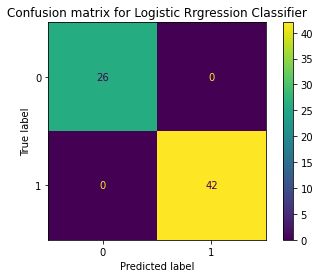

In [ ]:
confusionMatrixLogReg= skl.metrics.confusion_matrix(labelledDataTestWith16, logRegLabels, labels=[1, 2])
scatterMatrixLogReg = skl.metrics.ConfusionMatrixDisplay(confusion_matrix= confusionMatrixLogReg)
scatterMatrixLogReg.plot()
plt.title("Confusion matrix for Logistic Regression Classifier")

Text(0, 0.5, 'Length ->')

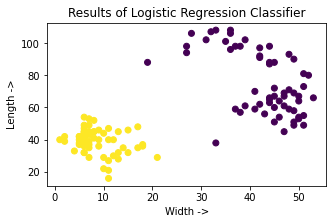

In [ ]:
plt.figure(1, figsize=(5, 3))
#plt.clf()
plt.scatter(dataForClassificationTrain["Width"], y=dataForClassificationTrain["Length"], c= labelledDataTrainArray, zorder=20)
plt.title("Results of Logistic Regression Classifier")
plt.xlabel("Width ->")
plt.ylabel("Length ->")

# loss = sc.special.expit(dataForClassificationTestWith16 * logRegModel.coef_ + logRegModel.intercept_).ravel()
# plt.plot(dataForClassificationTest, loss, color="red", linewidth=3)

In [ ]:
dataForClassificationTrain["Width"]

151    49
39     41
123    42
163    32
29     43
       ..
166    11
157    36
154     8
146    18
94      7
Name: Width, Length: 120, dtype: int64

### Evaluation Metrics

tools to assess the classification model are:
* confusion matrix,
* accuracy,
* cost-sensitive accuracy,
* precision/recall

### Using Clustering method KMeans for Classification (Optional)

Since classification is just assigning new data to pre-identified groups, we can determine these groups by performing clustering on data and label these groups accordingly.

In [ ]:
kMeansClusteringModel = KMeans(n_clusters = 2)
kMeansClusteringModel.fit(dataForClassificationTrain, labelledDataTrain)

KMeans(n_clusters=2)

In [ ]:
kMeansClusteringModelLabels = kMeansClusteringModel.predict(dataForClassificationTest)

In [ ]:
kMeansClusteringModelLabelsAdjusted = [x+1 for x in kMeansClusteringModelLabels]


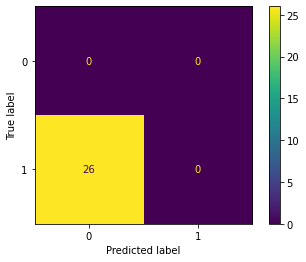

In [ ]:
confusionMatrixExtraTree = skl.metrics.confusion_matrix(labelledDataTest, kMeansClusteringModelLabels, labels=[1, 2])
scatterMatrixET = skl.metrics.ConfusionMatrixDisplay(confusion_matrix= confusionMatrixExtraTree)
scatterMatrixET.plot()

In [ ]:
kMeansClusteringModel.score(dataForClassificationTestWith16, labelledDataTestWith16)
#print (predictedLabelsDT16)
print (f"Accuracy of prediction on test set is - {round(accETWith16 * 100, 5)} %")

Accuracy of prediction on test set is - 98.52941 %


### RDE - (Ignore)

In [ ]:
labelled_data = pd.concat([images_data, labels], axis=1)
#labelled_data

#### **RDE**

 The core of RDE is the data
density, which, if use Euclidean type of distance, has the form of Cauchy kernel
function as it was shown in Chap. 

#### **RDE plots**

In [ ]:
#@title
def RDE(data):
    D = np.zeros(data.shape[0])
    MeanD = np.zeros(data.shape[0])
    VarD = np.zeros(data.shape[0])
    
    for pos in range (len(data)):
        k = pos+1   
        if (pos == 0):
            mean = data[0]
        else:
            mean = (1/k) * data[pos] + ((k-1)/k) * mean
        
        # get new std dev
        if (pos ==0):
            stdDev = np.dot( data [0] , data [0])
        else:
            stdDev = ((k - 1)/k) * stdDev + np.dot( data [pos], data [pos ])/k
        
        # get new RDE
        D[pos]= (1 / (1 +stdDev + ( (data [pos] - mean)*(data [pos] -mean) ) - (mean*mean)))
        
        # update mean
        
        if (pos == 0):
            MeanD [0] = D[0]
        else :
            MeanD [pos] = ((k - 1) / k) * MeanD [pos - 1] + (1/k) *D[pos]
            
        if (pos == 0):
            VarD [0] = 0
        else :
            VarD [pos ] = (((k - 1) / k) * VarD [pos - 1] )+ ((1/ k) *(D[pos] - MeanD [pos])*(D[pos] - MeanD [pos]))

    return D, MeanD , VarD

In [ ]:
labelled_data
cars_data = labelled_data[labelled_data["Label"] == 1]
bike_data = labelled_data[labelled_data["Label"] == 2]
print (len(cars_data), len(bike_data))

86 102


In [ ]:
[Density, MeanD, VarD] = RDE(np.array(labelled_data["Area"]))
stdD = np.sqrt(VarD)

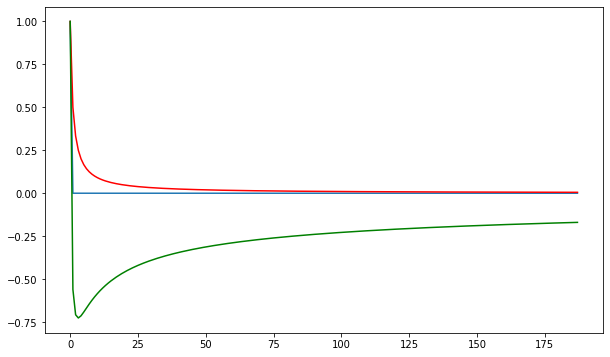

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(Density)
plt.plot(MeanD,'r')
plt.plot(MeanD - 3*stdD,'g')

In [ ]:
np.array(cars_data["Area"])

array([2115, 2632, 2484, 2700, 2499, 2499, 2408, 2650, 2604, 2805, 2166,
       2419, 2401, 2295, 2508, 2379, 2484, 2183, 2700, 2944, 2665, 2508,
       1254, 2925, 2867, 2860, 2736, 2542, 2772, 2970, 2904, 2842, 3036,
       2870, 3200, 3015, 2832, 3150, 3149, 3498, 3408, 3700, 3723, 3240,
       3350, 3243, 3381, 4160, 4176, 3872, 1672, 3588, 4150, 3864, 3960,
       3822, 3626, 3880, 4092, 4183, 4085, 4464, 4074, 3939, 3724, 3978,
       4131, 4410, 4312, 3564, 3816, 3456, 3888, 3424, 3328, 3456, 3306,
       3162, 3535, 3458, 3468, 3267, 2968, 3828, 2646, 2538])

In [ ]:
[Density, MeanD, VarD] = RDE(np.array(cars_data["Area"]))
stdD = np.sqrt(VarD)

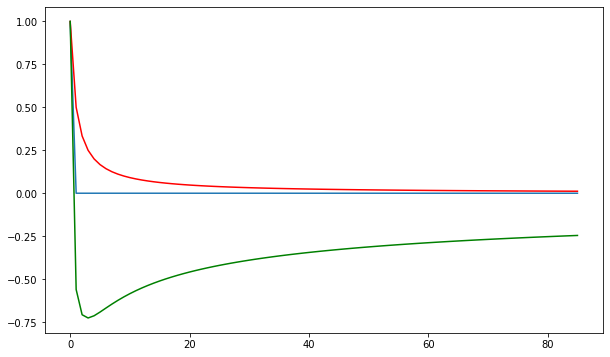

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(Density)
plt.plot(MeanD,'r')
plt.plot(MeanD - 3*stdD,'g')
